In [5]:
from pathlib import Path
import torch
import numpy as np
import zuko
import dill
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.lga.lga_training import WeatherThreshold, ClusterThreshold

rng_seed = 1
# pyro.set_rng_seed(int(rng_seed))
torch.manual_seed(int(rng_seed))
np.random.seed(int(rng_seed))

In [20]:
dir_path = Path.cwd()

# /bayes-air-atrds-attempt-8/checkpoints/nsf_730
ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_730/final/output_dict.pkl'

extras_path = dir_path / 'extras'

processed_visibility = pd.read_csv(extras_path / 'processed_visibility.csv')
visibility_dict = dict(processed_visibility.values)
processed_ceiling = pd.read_csv(extras_path / 'processed_ceiling.csv')
ceiling_dict = dict(processed_ceiling.values)

with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

device = torch.device('cpu')

wt = WeatherThreshold(50., device, 0., 0.)
ct = ClusterThreshold(50., device, 0., 0.) # dummy init

wt.load_state_dict(output_dict['wt_state_dict'])
ct.load_state_dict(output_dict['ct_state_dict'])

print(wt.visibility_threshold)
print(wt.ceiling_threshold)
print(wt.a)

print(ct.visibility_threshold)
print(ct.ceiling_threshold)
print(ct.a)

days = output_dict["config"]["days"]
print(days)
# print(wt.assign_label(1,1))

Parameter containing:
tensor(1.3918, requires_grad=True)
Parameter containing:
tensor(1.3178, requires_grad=True)
tensor(50.)
Parameter containing:
tensor(1.6003, requires_grad=True)
Parameter containing:
tensor(1.2757, requires_grad=True)
tensor(50.)
['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018

In [27]:
visibility_list = []
ceiling_list = []
label_list = []
for day in days:
    v = visibility_dict[day]
    c = ceiling_dict[day]
    visibility_list.append(v)
    ceiling_list.append(c)
    label_list.append(wt.assign_label(v,c).detach().cpu().item())

df = pd.DataFrame(
    {
        "visibility": visibility_list,
        "ceiling": ceiling_list,
        "label": label_list
    }
)

display(df)

# fig, ax = plt.subplots()
# ax.scatter(df.ceiling, df.visibility, c=df.label)

,visibility,ceiling,label
0,10.000,10000.000000,0.000000
1,10.000,9389.054318,0.000000
2,10.000,6519.498195,0.000000
3,0.402,441.771478,1.000000
4,10.000,8935.381432,0.000000
...,...,...,...
725,10.000,1340.495631,0.243084
726,10.000,4540.601467,0.000000
727,2.414,583.897070,1.000000
728,2.414,208.502590,1.000000


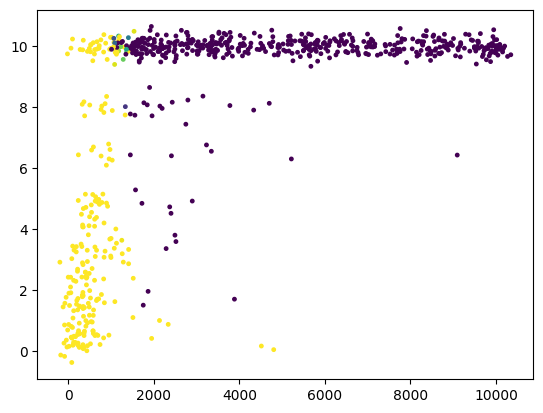

In [42]:
fig, ax = plt.subplots()

x = df.ceiling
y = df.visibility
z = df.label

def rand_jitter(arr, k=.01):
    stdev = (.01 if k is None else k) * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, k=None, **kwargs):
    return ax.scatter(rand_jitter(x, k), rand_jitter(y, k), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

jitter(ax, x, y, c=z, k=.02, s=6)
